# A Multiplicative CARMA Model for GRB Data

Let's start with the INTEGRAL data, which is not highly affected by dead time and saturation.

We need to implement a CARMA model

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

import numpy as np
import scipy.io

# Need both Jax and Tensorflow Probability 
import jax
# Important to enable 64-bit precision
jax.config.update("jax_enable_x64", True)

import jax.numpy as jnp
from jax import random
import tensorflow_probability.substrates.jax as tfp

# TinyGP for Gaussian Processes, JaxNS and numpyro for sampling
from tinygp import GaussianProcess, kernels
from tinygp.kernels.quasisep import CARMA

from jaxns.utils import resample
import numpyro
import numpyro.distributions as dist
from numpyro.infer.autoguide import AutoNormal

#stingray imports
import stingray
from stingray import Lightcurve, Powerspectrum
from stingray.modeling.gpmodeling import get_kernel, get_mean
from stingray.modeling.gpmodeling import get_prior, get_log_likelihood, get_gp_params
from stingray.modeling.gpmodeling import _skew_gaussian

# suppress warnings
import warnings
warnings.filterwarnings("ignore")

# abbreviations for tensorflow distributions + bijectors
tfpd = tfp.distributions
tfpb = tfp.bijectors


INFO[2023-11-05 22:11:39,425]: Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
I0000 00:00:1699218699.424647       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
INFO[2023-11-05 22:11:39,427]: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO[2023-11-05 22:11:39,433]: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/opt/miniconda3/envs/grbsearch/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file), '/usr/local/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache)
/Users/daniela/work/repositories/stingraysoftware/stingray/stingray/utils.py:35: UserWarning: pyfftw not installed. Using standard scipy fft
  warnings.warn(

## Latent GP Model with CARMA + Numpyro

Let's generate some data:

INFO[2023-11-05 22:18:51,214]: Checking if light curve is well behaved. This can take time, so if you are sure it is already sorted, specify skip_checks=True at light curve creation.
INFO[2023-11-05 22:18:51,215]: Checking if light curve is sorted.
INFO[2023-11-05 22:18:51,215]: Computing the bin time ``dt``. This can take time. If you know the bin time, please specify it at light curve creation


-1938606097.6619604


<IPython.core.display.Javascript object>


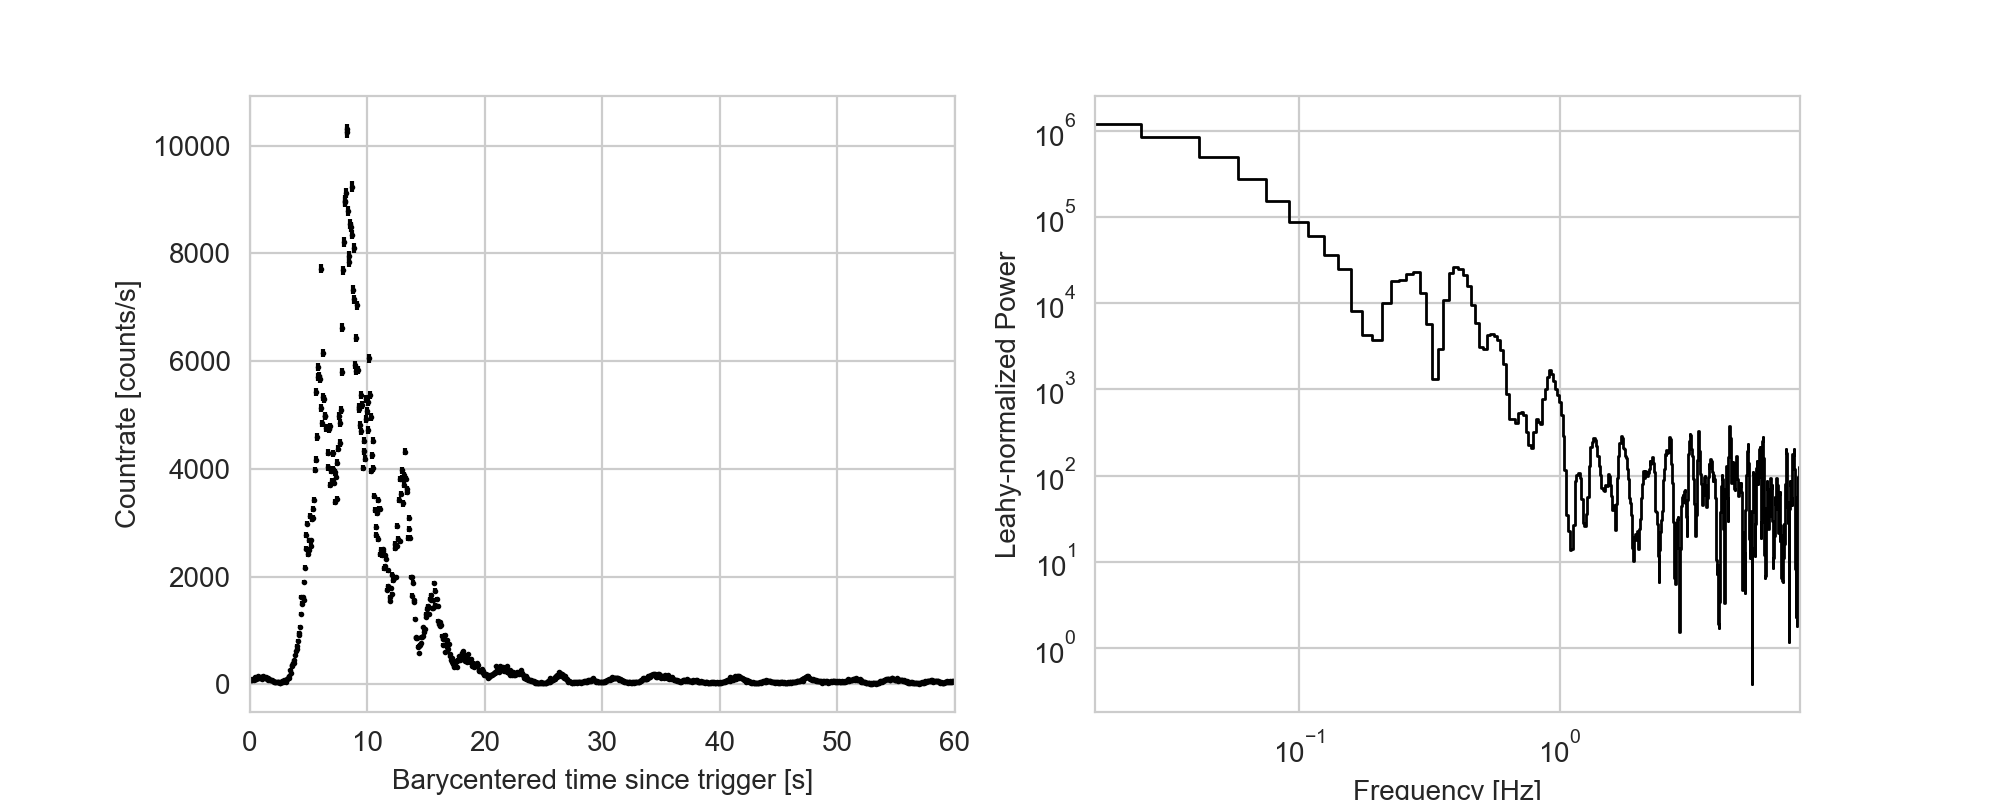

In [26]:
#alpha = [.8, 1.2, 1.7]
#beta = [1.5]
#sigma = 1e5

alpha = [3.5, 1.5]
beta = [1.7]
sigma = 4

skew_amp = 2.2
skew_t0 = 6.0
skew_sig1 = 2.0
skew_sig2 = 10.0


kernel_params_true = {"alpha": alpha,
                      "beta": beta,
                      "acarma": sigma}
mean_params_true = {"A": skew_amp, 
                    "t0": skew_t0, 
                    "sig1": skew_sig1, 
                    "sig2": skew_sig2}

time = np.linspace(0, 60, int(50/0.05))

mean = _skew_gaussian(time, mean_params_true) + 2
#mean = np.ones_like(time)

kernel = CARMA.init(alpha=alpha, beta=beta)
gp = GaussianProcess(kernel, time, mean_value=mean, diag=0.01)

key = random.PRNGKey(100)
#print(gp.sample(key))
sample = np.exp(gp.sample(key) + mean)
#print(sample)
#sample = gp.sample(key)
sample = np.random.poisson(sample)

#err = np.random.normal(0.0, np.sqrt(np.abs(sample)))
#sample = sample + err

gp.condition(sample)
print(gp.log_probability(sample))
lcsample = Lightcurve(time, sample)
pssample = Powerspectrum(lcsample, norm="leahy")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

ax1.errorbar(lcsample.time, lcsample.counts, yerr=np.sqrt(np.abs(lcsample.counts)), 
             fmt="o", markersize=1, color="black")
ax1.set_xlim(lcsample.time[0], lcsample.time[-1])
ax1.set_xlabel("Barycentered time since trigger [s]")
ax1.set_ylabel("Countrate [counts/s]")

ax2.loglog(pssample.freq, pssample.power, ds="steps-mid", lw=1, color="black")
ax2.set_xlim(pssample.freq[0], pssample.freq[-1])
ax2.set_xlabel("Frequency [Hz]")
ax2.set_ylabel("Leahy-normalized Power")
#ax1.set_ylim(0, 200)

def plot_kernel(kernel, **kwargs):
    dx = np.linspace(0, 5, 100)
    plt.figure()
    plt.plot(dx, kernel(dx, dx[:1]), **kwargs)
    plt.xlabel("dx")
    plt.ylabel("k(dx)")


#plot_kernel(kernel)

In [ ]:
alpha = [3.5, 4.5, 2.0]
beta = [1.5]
sigma = 4

In [ ]:
def model(x, y=None):
 
    # parameters for the mean function
    #loga = numpyro.sample("loga", dist.Uniform(8, 15))
    #t0 = numpyro.sample("t0", dist.Uniform(0.1, 20.0))
    #logsig1 = numpyro.sample("logsig1", dist.Uniform(-3, 1))
    #logsig2 = numpyro.sample("logsig2", dist.Uniform(1, 4))
    #logconst = numpyro.sample("logconst", dist.Uniform(7, 10))
    
    #mean_vals = skewgaussian(x, [loga, t0, logsig1, logsig2, logconst])

    # The parameters of the GP model    
    log_alpha1 = numpyro.sample("alpha1", dist.Uniform(-2,4))
    log_alpha2 = numpyro.sample("alpha2", dist.Uniform(-2, 4))
    log_alpha3 = numpyro.sample("alpha3", dist.Uniform(-2, 4))

    log_beta = numpyro.sample("beta", dist.Uniform(-2, 4))
    log_sigma = numpyro.sample("sigma", dist.Uniform(-1, 4))
    
    #print(alpha1)
    # Set up the kernel and GP objects
    kernel = CARMA.init(
        alpha= [jnp.exp(log_alpha1), jnp.exp(log_alpha2), jnp.exp(log_alpha3)], 
        beta= [jnp.exp(log_beta)], 
        sigma= jnp.exp(log_sigma)
    )
    gp = GaussianProcess(kernel, x, diag=0.01)

    # This parameter has shape (num_data,) and it encodes our beliefs about
    # the process rate in each bin
    log_rate = numpyro.sample("log_rate", gp.numpyro_dist())

    # Finally, our observation model is Poisson
    numpyro.sample("obs", dist.Poisson(jnp.exp(log_rate)), obs=y)

    #numpyro.sample("gp", gp.numpyro_dist(), obs=y)

    #if y is not None:
    #    numpyro.deterministic("pred", gp.condition(y, x).gp.loc)

#def guide(x, y=None):
#    mu = numpyro.param(
#        "log_rate_mu", jnp.zeros_like(x) if y is None else jnp.log(y + 1)
#    )
#    sigma = numpyro.param(
#        "log_rate_sigma",
#        jnp.ones_like(x),
#        constraint=dist.constraints.positive,
#    )
#    numpyro.sample("log_rate", dist.Independent(dist.Normal(mu, sigma), 1))


In [6]:
npoints = lcsample.n
optim = numpyro.optim.Adam(0.01)
guide = AutoNormal(model)
svi = numpyro.infer.SVI(model, guide, optim, numpyro.infer.Trace_ELBO(10))
results = svi.run(jax.random.PRNGKey(55873), 3000, time[:npoints], y=sample[:npoints], progress_bar=True)


100%|██| 3000/3000 [00:48<00:00, 61.46it/s, init loss: 79383.9708, avg. loss [2851-3000]: 2708.2182]


<IPython.core.display.Javascript object>


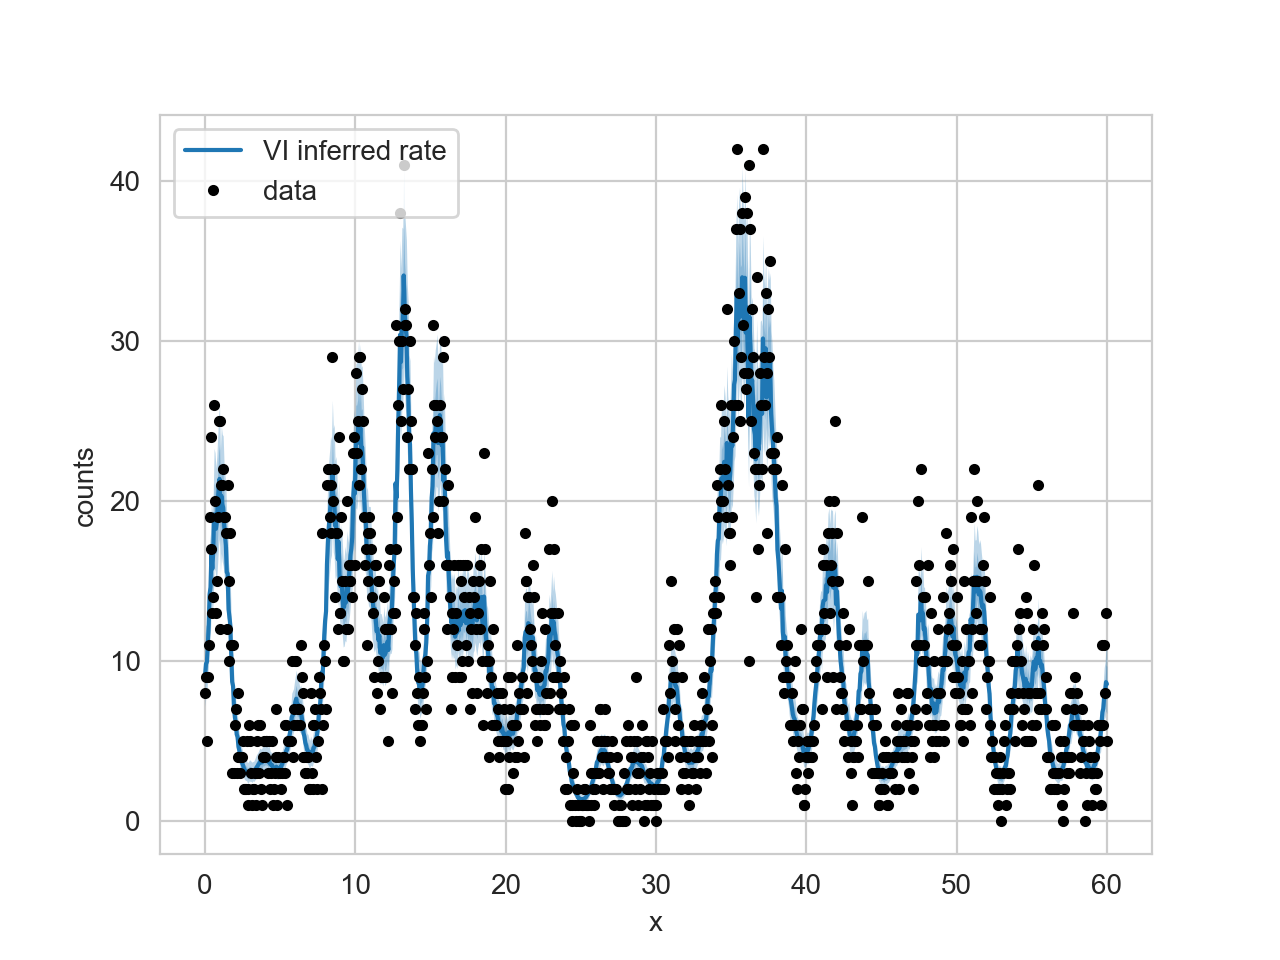

In [8]:
mu = results.params["log_rate_auto_loc"]
sigma = results.params["log_rate_auto_scale"]
plt.figure()
plt.plot(time[:npoints], np.exp(mu), color="C0", label="VI inferred rate")
plt.fill_between(
    time[:npoints],
    np.exp(mu - 2 * sigma),
    np.exp(mu + 2 * sigma),
    alpha=0.3,
    lw=0,
    color="C0",
)
plt.fill_between(time[:npoints], np.exp(mu - sigma), np.exp(mu + sigma), alpha=0.3, lw=0, color="C0")
#plt.plot(time[:npoints], np.exp(true_log_rate), "--", color="C1", label="true rate")
plt.plot(time[:npoints], sample[:npoints], ".k", label="data")
plt.legend(loc=2)
plt.xlabel("x")
_ = plt.ylabel("counts")


In [9]:
samples = guide.sample_posterior(random.PRNGKey(1), results.params, (1000,))
numpyro.diagnostics.print_summary(samples, prob=0.89, group_by_chain=False)


                   mean       std    median      5.5%     94.5%     n_eff     r_hat
       alpha1     -1.39      0.05     -1.39     -1.47     -1.31    981.10      1.00
       alpha2      2.34      0.07      2.34      2.24      2.45    944.35      1.00
       alpha3      1.25      0.19      1.25      0.95      1.55   1063.81      1.00
         beta     -0.26      0.07     -0.25     -0.37     -0.16   1107.81      1.00
  log_rate[0]      2.21      0.13      2.21      2.03      2.43    931.48      1.00
  log_rate[1]      2.28      0.11      2.28      2.07      2.43    957.45      1.00
  log_rate[2]      2.30      0.10      2.30      2.14      2.46    988.30      1.00
  log_rate[3]      2.40      0.11      2.40      2.23      2.56    779.32      1.00
  log_rate[4]      2.51      0.10      2.51      2.34      2.67    884.91      1.00
  log_rate[5]      2.65      0.10      2.65      2.48      2.81    943.43      1.00
  log_rate[6]      2.68      0.10      2.68      2.52      2.84   1024.08  

In [10]:
var_names = ["alpha1", "alpha2", "alpha3", "beta", "sigma"]

In [11]:
log_alpha = np.log([3.5, 4.5, 2.0])
log_beta = np.log([1.5])
log_sigma = np.log(4)

true_log_pars = np.hstack([log_alpha, log_beta, log_sigma])

<IPython.core.display.Javascript object>


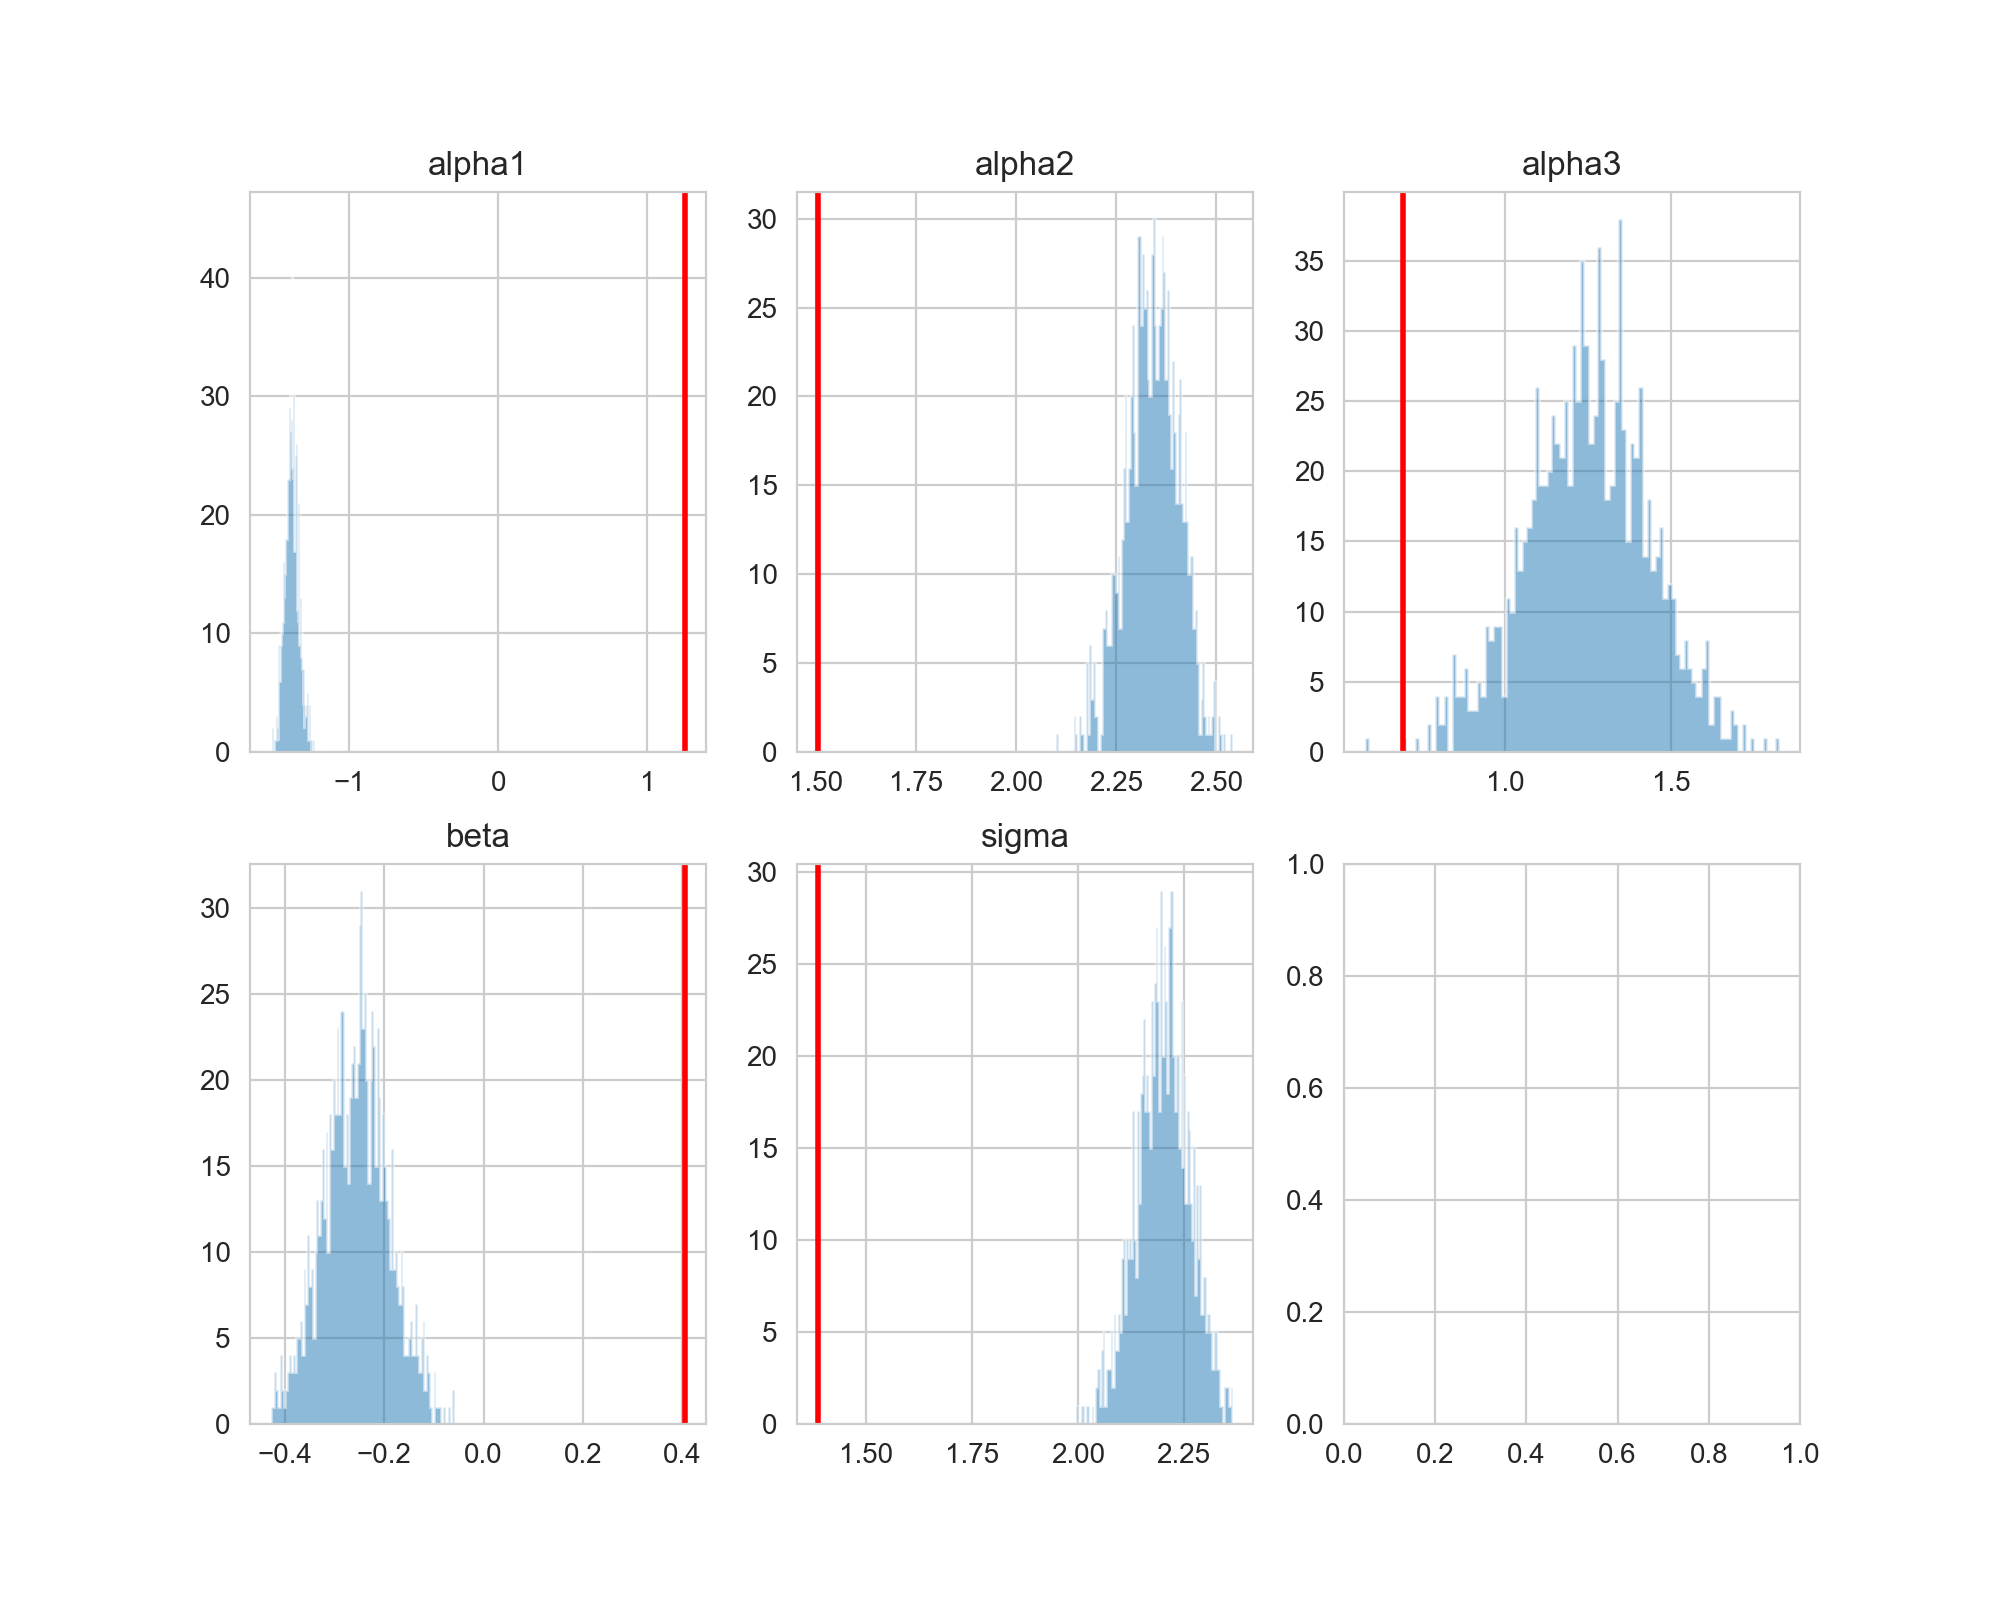

In [12]:
fig, axes = plt.subplots(2, 3, figsize=(10, 8))

axes = np.hstack(axes)

for i, vn in enumerate(var_names):
    axes[i].hist(samples[vn], bins=100, histtype="stepfilled", alpha=0.5)
    axes[i].set_title(vn)
    axes[i].axvline(true_log_pars[i], lw=2, color="red")

In [13]:
list(samples.keys())

['alpha1', 'alpha2', 'alpha3', 'beta', 'log_rate', 'sigma']

<IPython.core.display.Javascript object>


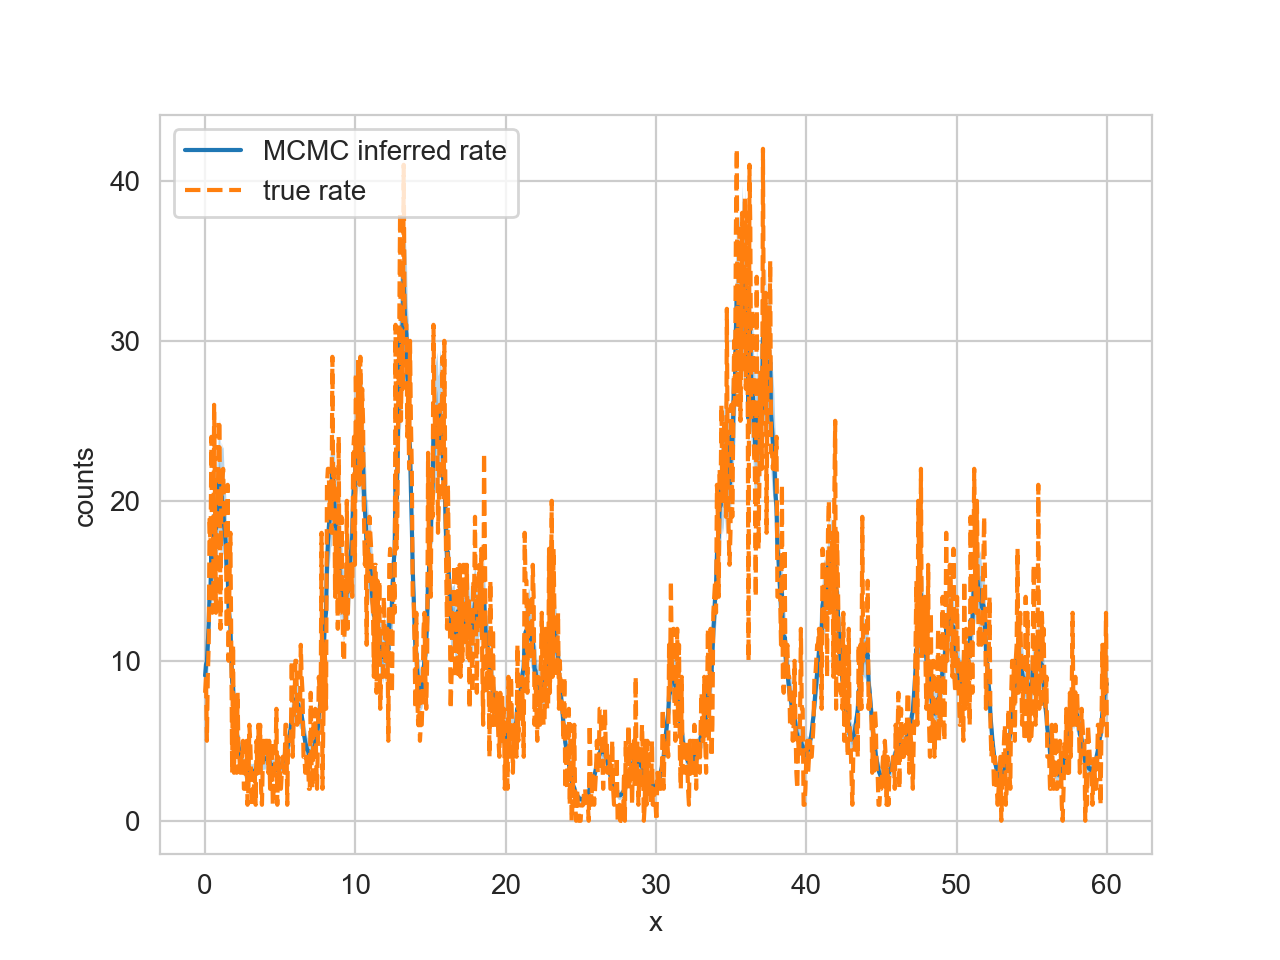

In [14]:
q = np.percentile(samples["log_rate"], [5, 25, 50, 75, 95], axis=0)
plt.figure()
plt.plot(time[:npoints], np.exp(q[2]), color="C0", label="MCMC inferred rate")
plt.fill_between(time[:npoints], np.exp(q[0]), np.exp(q[-1]), alpha=0.3, lw=0, color="C0")
plt.fill_between(time[:npoints], np.exp(q[1]), np.exp(q[-2]), alpha=0.3, lw=0, color="C0")
plt.plot(time[:npoints], sample[:npoints], "--", color="C1", label="true rate")
#plt.plot(x, y, ".k", label="data")
plt.legend(loc=2)
plt.xlabel("x")
_ = plt.ylabel("counts")


### Including a Multiplicative Mean Function

In [7]:
def power_spectrum(freq, sigma, ar_coef, ma_coefs=[1.0]):
    """
    FROM CARMApack (Kelly et al, 2014)
    
    Return the power spectrum for a CARMA(p,q) process calculated at the input frequencies.

    :param freq: The frequencies at which to calculate the PSD.
    :param sigma: The standard deviation driving white noise.
    :param ar_coef: The CARMA model autoregressive coefficients.
    :param ma_coefs: Coefficients of the moving average polynomial

    :rtype : The power spectrum at the input frequencies, a numpy array.
    """
    try:
        len(ma_coefs) <= len(ar_coef)
    except ValueError:
        "Size of ma_coefs must be less or equal to size of ar_roots."

    ma_poly = np.polyval(ma_coefs[::-1], 2.0 * np.pi * 1j * freq)  # Evaluate the polynomial in the PSD numerator
    ar_poly = np.polyval(ar_coef, 2.0 * np.pi * 1j * freq)  # Evaluate the polynomial in the PSD denominator
    pspec = sigma ** 2 * np.abs(ma_poly) ** 2 / np.abs(ar_poly) ** 2
    return pspec

In [ ]:
def skewgaussian(t, params):
    #parameter_names = ("logA", "t0", "logsig1", "logsig2")
    logA = params[0]
    t0 = params[1]
    logsig1 = params[2]
    logsig2 = params[3]

    y = jnp.exp(logA) * jnp.where(
            t > t0,
            jnp.exp(-((t - t0) ** 2) / (2 * (jnp.exp(logsig2)**2))),
            jnp.exp(-((t - t0) ** 2) / (2 * (jnp.exp(logsig1)**2))),
        )
    return y

INFO[2023-10-09 15:15:08,129]: Checking if light curve is well behaved. This can take time, so if you are sure it is already sorted, specify skip_checks=True at light curve creation.
INFO[2023-10-09 15:15:08,130]: Checking if light curve is sorted.
INFO[2023-10-09 15:15:08,130]: Computing the bin time ``dt``. This can take time. If you know the bin time, please specify it at light curve creation


-28052813.93695411


<IPython.core.display.Javascript object>


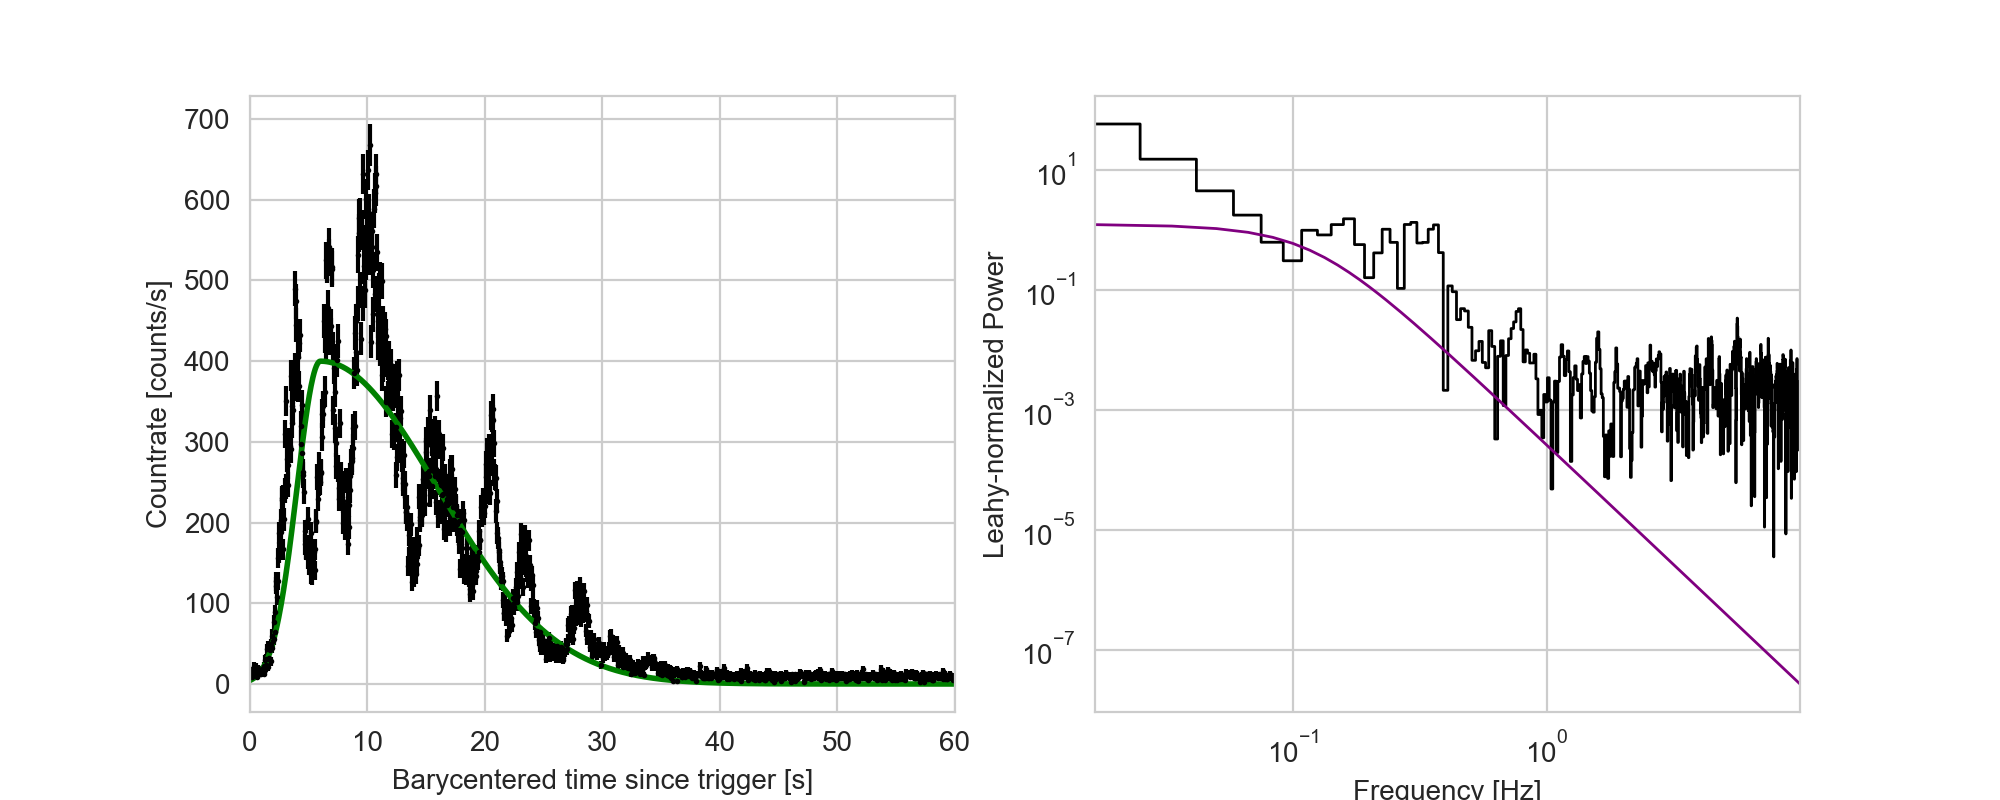

<IPython.core.display.Javascript object>


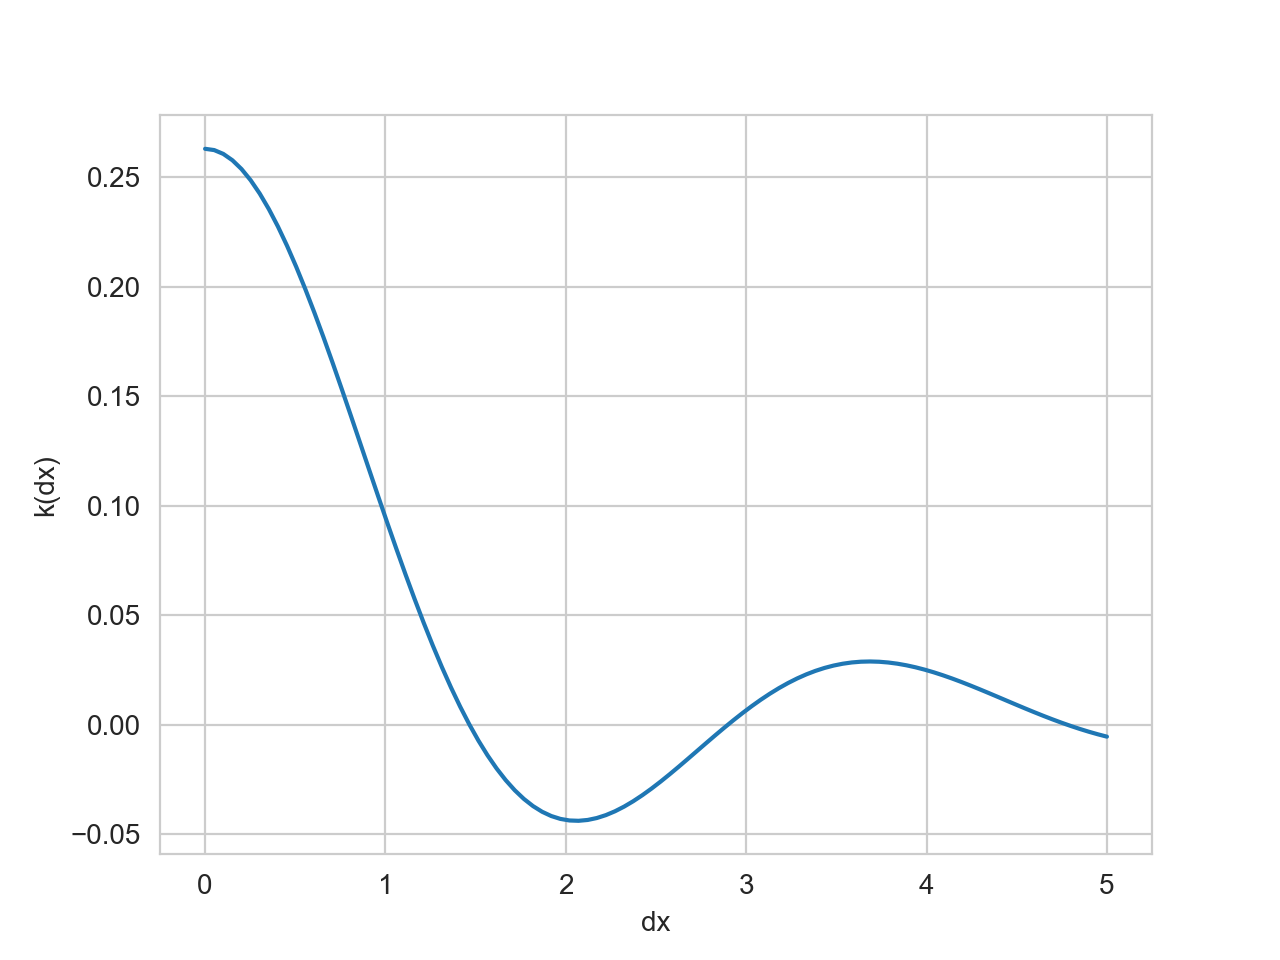

In [10]:
# Make a time array
dt = 0.05
tseg = 60.0

time = np.linspace(0, 60, int(60/0.05))

alpha = [3.5, 4.5, 2.0]
beta = [1.5]
sigma = 1.5

skew_amp = 400
skew_t0 = 6.0
skew_sig1 = 2.0
skew_sig2 = 10.0
const = 10.0


mean_params_true = [np.log(skew_amp),
               skew_t0,
               np.log(skew_sig1),
               np.log(skew_sig2),]


mean_val = skewgaussian(time, mean_params_true)

#kernel_params_true = {"alpha": alpha,
#                      "beta": beta,
#                      "acarma": sigma}

kernel_params_true = np.hstack([alpha, beta, sigma])

kernel = CARMA.init(alpha=alpha, beta=beta, sigma=sigma)
gp = GaussianProcess(kernel, time, diag=0.01)

key = random.PRNGKey(1200)
sample = jnp.exp(gp.sample(key)) * mean_val + const
sample = np.random.poisson(sample)

gp.condition(sample)
print(gp.log_probability(sample))

lcsample = Lightcurve(time, sample)
pssample = Powerspectrum(lcsample, norm="frac")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

ax1.errorbar(lcsample.time, lcsample.counts, yerr=np.sqrt(np.abs(lcsample.counts)), 
             fmt="o", markersize=1, color="black")
ax1.plot(time, mean_val, lw=2, color="green")

ax1.set_xlim(lcsample.time[0], lcsample.time[-1])
ax1.set_xlabel("Barycentered time since trigger [s]")
ax1.set_ylabel("Countrate [counts/s]")


ps_carma = power_spectrum(pssample.freq, sigma, alpha, beta)

ax2.loglog(pssample.freq, pssample.power, ds="steps-mid", lw=1, color="black")
ax2.loglog(pssample.freq, ps_carma, lw=1, color="purple")
ax2.set_xlim(pssample.freq[0], pssample.freq[-1])
ax2.set_xlabel("Frequency [Hz]")
ax2.set_ylabel("Leahy-normalized Power")


def plot_kernel(kernel, **kwargs):
    dx = np.linspace(0, 5, 100)
    plt.figure()
    plt.plot(dx, kernel(dx, dx[:1]), **kwargs)
    plt.xlabel("dx")
    plt.ylabel("k(dx)")


plot_kernel(kernel)

In [11]:
np.log(skew_amp)

5.991464547107982

In [17]:
alpha = [3.5, 4.5, 2.0]
beta = [1.5]
sigma = 1.5

skew_amp = 400
skew_t0 = 6.0
skew_sig1 = 2.0
skew_sig2 = 10.0
const = 10.0


In [15]:
np.log(10)

2.302585092994046

In [20]:
def model_with_mean(x, y=None):
 
    # mean parameters
    log_amp = numpyro.sample('log_amp', dist.Uniform(2, 7))
    t0 = numpyro.sample("t0", dist.Uniform(2, 10))
    log_sig1 = numpyro.sample("log_sig1", dist.Uniform(-1, 1.5))
    log_sig2 = numpyro.sample("log_sig2", dist.Uniform(1, 3))

    params = [log_amp, t0, log_sig1,log_sig2]
    
    mean = skewgaussian(x, params)
    
    # kernel parameters
    log_alpha1 = numpyro.sample("log_alpha1", dist.Uniform(-1, 2.5))
    log_alpha2 = numpyro.sample("log_alpha2", dist.Uniform(-1, 2.5))
    log_alpha3 = numpyro.sample("log_alpha3", dist.Uniform(-1, 2.5))
    
    log_beta = numpyro.sample("log_beta", dist.Uniform(-1, 2.5))
    log_sigma = numpyro.sample("log_sigma", dist.Uniform(0, 5.3))
    
    
    kernel = CARMA.init(alpha=[jnp.exp(log_alpha1), jnp.exp(log_alpha2), jnp.exp(log_alpha3)], 
                        beta=[jnp.exp(log_beta)], sigma=jnp.exp(log_sigma))
    
    gp = GaussianProcess(kernel, x, diag=0.01)  
        
    # This parameter has shape (num_data,) and it encodes our beliefs about
    # the process rate in each bin
    log_rate = numpyro.sample("log_rate", gp.numpyro_dist())

    # Finally, our observation model is Poisson
    numpyro.sample("obs", dist.Poisson(jnp.exp(log_rate) + mean), obs=y)

    #numpyro.sample("gp", gp.numpyro_dist(), obs=y)

    #if y is not None:
    #    numpyro.deterministic("pred", gp.condition(y, x).gp.loc)

#def guide(x, y=None):
#    mu = numpyro.param(
#        "log_rate_mu", jnp.zeros_like(x) if y is None else jnp.log(y + 1)
#    )
#    sigma = numpyro.param(
#        "log_rate_sigma",
#        jnp.ones_like(x),
#        constraint=dist.constraints.positive,
#    )
#    numpyro.sample("log_rate", dist.Independent(dist.Normal(mu, sigma), 1))


In [ ]:
npoints = lcsample.n
optim = numpyro.optim.Adam(0.01)
guide = AutoNormal(model_with_mean)
svi = numpyro.infer.SVI(model_with_mean, guide, optim, numpyro.infer.Trace_ELBO(10))
results = svi.run(jax.random.PRNGKey(100), 3000, time[:npoints], y=sample[:npoints], progress_bar=True)


  2%|▉                                                            | 47/3000 [00:15<03:38, 13.51it/s]

**TODO**: The kernel keeps dying, and I'm not sure why. Need to investigate!

## Running this on the real data

To load the data, we'll have to read them from an IDL .sav file, which will return a dictionary with the relevant columns as keywords and the values in arrays:

In [2]:
#datadir = "/Users/danielahuppenkothen/work/repositories/grb230307a_qposearch/data/"
datadir = "/Users/daniela/work/data/grb230307A/"

data = scipy.io.readsav(datadir+"acs_lc_bary.sav")
data

{'barytime': array([-6.87185967, -6.82185948, -6.77185976, ..., 98.02814186,
        98.07813728, 98.12814033], dtype='>f8'),
 'counts': array([4502., 4570., 4576., ..., 4516., 4444., 4514.], dtype='>f4')}

Let's turn this into a `stingray.Lightcurve` object. On the way, we will also restrict it to the 0-60s time interval, and will take out the background:

In [3]:
barytime = np.array(data["barytime"], dtype=float)
counts = np.array(data["counts"], dtype=float)

# calculate background flux
mean_bkg = np.mean(counts[-100:])
print(mean_bkg)

# store in Lightcurve object, then truncate to 0-60s interval:
lc = Lightcurve(barytime, counts)# -mean_bkg)
minind = lc.time.searchsorted(0.0)
maxind = lc.time.searchsorted(60.0)
lc = lc.truncate(start=minind, stop=maxind, method="index")

# calculate periodogram for comparison:
ps = Powerspectrum(lc, norm="leahy")

INFO[2023-10-09 14:16:43,960]: Checking if light curve is well behaved. This can take time, so if you are sure it is already sorted, specify skip_checks=True at light curve creation.
INFO[2023-10-09 14:16:44,067]: Checking if light curve is sorted.


4569.8


INFO[2023-10-09 14:16:44,162]: Computing the bin time ``dt``. This can take time. If you know the bin time, please specify it at light curve creation


Let's plot the light curve and periodogram:

<IPython.core.display.Javascript object>


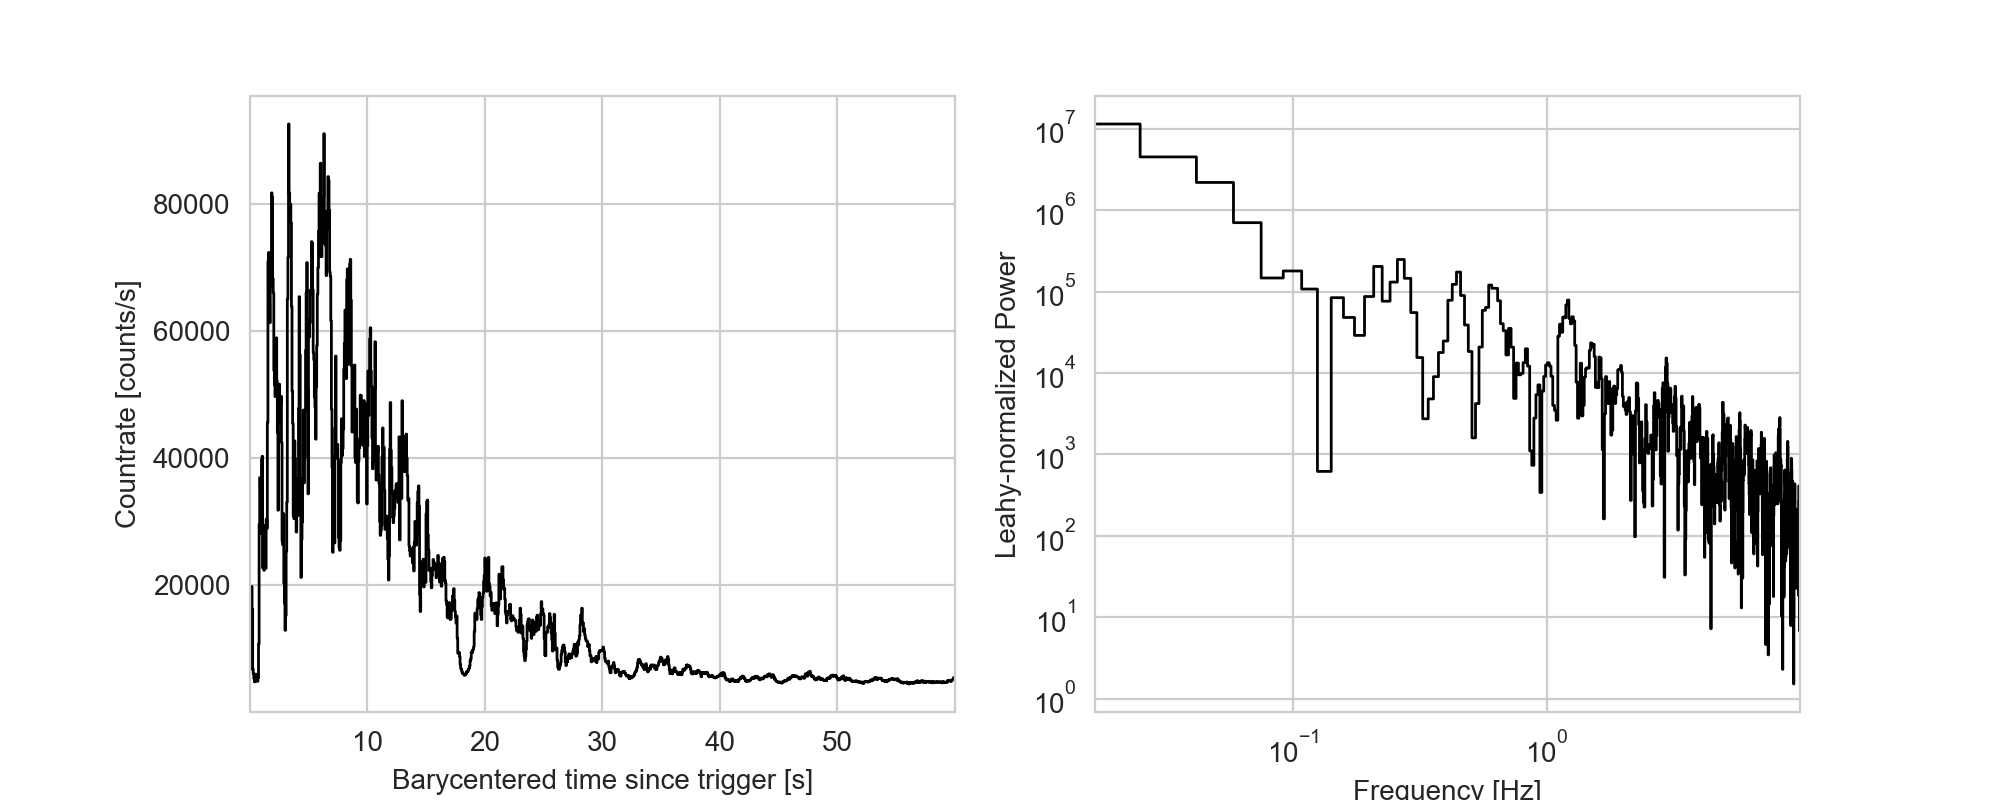

Text(0, 0.5, 'Leahy-normalized Power')

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

ax1.plot(lc.time, lc.counts, lw=1, color="black", ds="steps-mid")
ax1.set_xlim(lc.time[0], lc.time[-1])
ax1.set_xlabel("Barycentered time since trigger [s]")
ax1.set_ylabel("Countrate [counts/s]")

ax2.loglog(ps.freq, ps.power, ds="steps-mid", lw=1, color="black")
ax2.set_xlim(ps.freq[0], ps.freq[-1])
ax2.set_xlabel("Frequency [Hz]")
ax2.set_ylabel("Leahy-normalized Power")

In [5]:
np.max(counts)

92606.0